In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
torch.__version__

'1.11.0'

# 1. Dataset & Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
#MENYIAPKAN DATA TRAIN DAN DATA TEST

bs = 128 #jumlah batch_size (bs) pada minibatch nya

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('data/train/', transform= transform)
trainloader = DataLoader(train_set, batch_size= bs, shuffle=True)

test_set = datasets.ImageFolder('data/test', transform=transform)
testloader = DataLoader(test_set, batch_size= bs, shuffle=True)

#Di sini data train dan data testnya dishuffle
#Pada data test itu gak wajib dishuffle, tapi dalam hal ini mau dishuffle

In [5]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 1, 28, 28])

In [6]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# 2. Arsitektur & Config

In [7]:
from jcopdl.layers import linear_block

## 2.1 Arsitektur

In [8]:
class FashionClassifier(nn.Module):
    
    def __init__(self, input_size, n1, n2, output_size, dropout = 0.2):
        super().__init__()
        
        self.fc = nn.Sequential(
                                nn.Flatten(),
                                linear_block(input_size, n1, dropout=dropout),
                                linear_block(n1, n2, dropout= dropout),
                                linear_block(n2, output_size, activation='lsoftmax'
                                )
        )
        
        
    def forward (self, x):
        return self.fc(x)

## 2.2 Config

In [9]:
config = set_config({
                    'input_size': 784,
                    'n1': 256,
                    'n2': 64,
                    'output_size': len(train_set.classes),
                    'dropout': 0.2  
})

# 3. Training Preparation

In [10]:
from tqdm.auto import tqdm

In [11]:
model = FashionClassifier(config.input_size, config.output_size, config.n1, config.n2, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr= 0.001)
callback = Callback(model, config, outdir='model')

# 4. Training Model

In [12]:
#TRAINING MODEL

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    
    elif mode == 'test':
        model.eval()
        
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc = mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) #feedforward
        loss = criterion(output, target) #hitung loss
        
        if mode == 'train':
            loss.backward() #backpropagation 
            optimizer.step() #update weight
            optimizer.zero_grad() #zero gradient
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset) #menghitung nilai cost (total loss) berdasarkan cost yang didapatkan terhadap total (len) datasetnya (train_set dan test_set) yang ada
    acc = correct / len (dataset) #menghitung 'accuracy (acc)' berdasarkan prediksi yang benar (Correct) terhadap total (len) datasetnya (train_set dan test_set) yang ada
    
    return cost, acc

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.2616 | Test_cost  = 0.6510 | Train_score = 0.5394 | Test_score = 0.7722 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.7506 | Test_cost  = 0.5521 | Train_score = 0.7281 | Test_score = 0.8084 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6626 | Test_cost  = 0.5192 | Train_score = 0.7605 | Test_score = 0.8101 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.6257 | Test_cost  = 0.4855 | Train_score = 0.7756 | Test_score = 0.8296 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.6034 | Test_cost  = 0.4689 | Train_score = 0.7847 | Test_score = 0.8317 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5787 | Test_cost  = 0.4616 | Train_score = 0.7933 | Test_score = 0.8383 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.5647 | Test_cost  = 0.4706 | Train_score = 0.7970 | Test_score = 0.8341 |
==> EarlyStop patience =  1 | Best test_score: 0.8383


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.5593 | Test_cost  = 0.4706 | Train_score = 0.8011 | Test_score = 0.8315 |
==> EarlyStop patience =  2 | Best test_score: 0.8383


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.5506 | Test_cost  = 0.4755 | Train_score = 0.8031 | Test_score = 0.8257 |
==> EarlyStop patience =  3 | Best test_score: 0.8383


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.5468 | Test_cost  = 0.4516 | Train_score = 0.8040 | Test_score = 0.8379 |
==> EarlyStop patience =  4 | Best test_score: 0.8383


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.5422 | Test_cost  = 0.4485 | Train_score = 0.8075 | Test_score = 0.8387 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.5388 | Test_cost  = 0.4638 | Train_score = 0.8057 | Test_score = 0.8356 |
==> EarlyStop patience =  1 | Best test_score: 0.8387


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.5291 | Test_cost  = 0.4563 | Train_score = 0.8097 | Test_score = 0.8395 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.5285 | Test_cost  = 0.4444 | Train_score = 0.8111 | Test_score = 0.8427 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.5194 | Test_cost  = 0.4381 | Train_score = 0.8135 | Test_score = 0.8441 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.5218 | Test_cost  = 0.4371 | Train_score = 0.8151 | Test_score = 0.8444 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.5164 | Test_cost  = 0.4331 | Train_score = 0.8155 | Test_score = 0.8492 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.5111 | Test_cost  = 0.4580 | Train_score = 0.8182 | Test_score = 0.8300 |
==> EarlyStop patience =  1 | Best test_score: 0.8492


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.5126 | Test_cost  = 0.4306 | Train_score = 0.8161 | Test_score = 0.8467 |
==> EarlyStop patience =  2 | Best test_score: 0.8492


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.5079 | Test_cost  = 0.4410 | Train_score = 0.8168 | Test_score = 0.8463 |


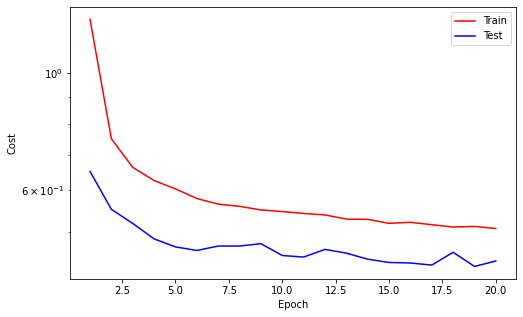

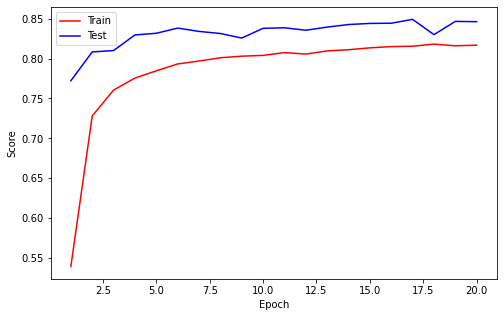

==> EarlyStop patience =  3 | Best test_score: 0.8492


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.5026 | Test_cost  = 0.4511 | Train_score = 0.8198 | Test_score = 0.8394 |
==> EarlyStop patience =  4 | Best test_score: 0.8492


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.5024 | Test_cost  = 0.4415 | Train_score = 0.8194 | Test_score = 0.8454 |
==> EarlyStop patience =  5 | Best test_score: 0.8492
==> Execute Early Stopping at epoch: 22 | Best test_score: 0.8492
==> Best model is saved at model


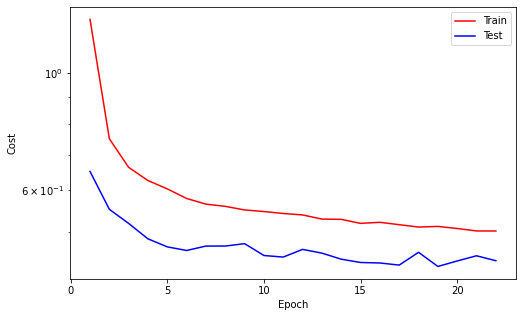

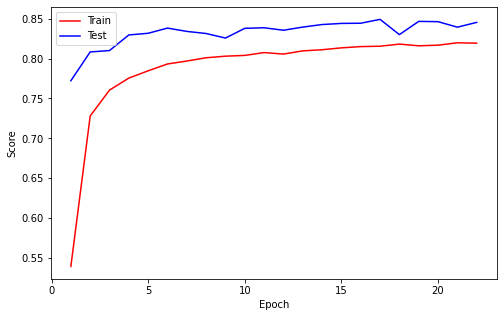

In [13]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    
    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
        
    #Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    #Checkpoint
    callback.save_checkpoint()
    
    #Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    #Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

# 5. Prediction

In [14]:
#LOAD MODEL

model

FashionClassifier(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Sequential(
      (0): Linear(in_features=784, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): LogSoftmax(dim=1)
    )
  )
)

In [15]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [16]:
#Prediksi cepat

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
    
[label2cat[preds] for preds in preds]

['Dress',
 'Sneaker',
 'Sneaker',
 'Dress',
 'Bag',
 'Trouser',
 'Dress',
 'T-shirt or Top',
 'Sandal',
 'Ankle boot',
 'T-shirt or Top',
 'Ankle boot',
 'Coat',
 'Ankle boot',
 'Pullover',
 'Sandal',
 'Sandal',
 'Sandal',
 'Sneaker',
 'T-shirt or Top',
 'Dress',
 'Shirt',
 'Ankle boot',
 'Sneaker',
 'Shirt',
 'Trouser',
 'Bag',
 'Ankle boot',
 'Sandal',
 'Coat',
 'Coat',
 'T-shirt or Top',
 'Trouser',
 'Dress',
 'Sneaker',
 'Ankle boot',
 'Sandal',
 'Dress',
 'T-shirt or Top',
 'Dress',
 'Pullover',
 'Dress',
 'Coat',
 'Shirt',
 'Shirt',
 'Coat',
 'Dress',
 'Coat',
 'Sandal',
 'Sandal',
 'Dress',
 'T-shirt or Top',
 'Bag',
 'Shirt',
 'Coat',
 'Shirt',
 'Sandal',
 'Trouser',
 'Coat',
 'T-shirt or Top',
 'Sandal',
 'Ankle boot',
 'Shirt',
 'Bag',
 'Trouser',
 'Ankle boot',
 'Trouser',
 'Sandal',
 'Trouser',
 'Sneaker',
 'T-shirt or Top',
 'Trouser',
 'Coat',
 'Shirt',
 'Bag',
 'T-shirt or Top',
 'Sneaker',
 'Ankle boot',
 'Dress',
 'Bag',
 'Sneaker',
 'Dress',
 'Shirt',
 'T-shirt or Top

# 6. Visulaization

In [17]:
import matplotlib.pyplot as plt

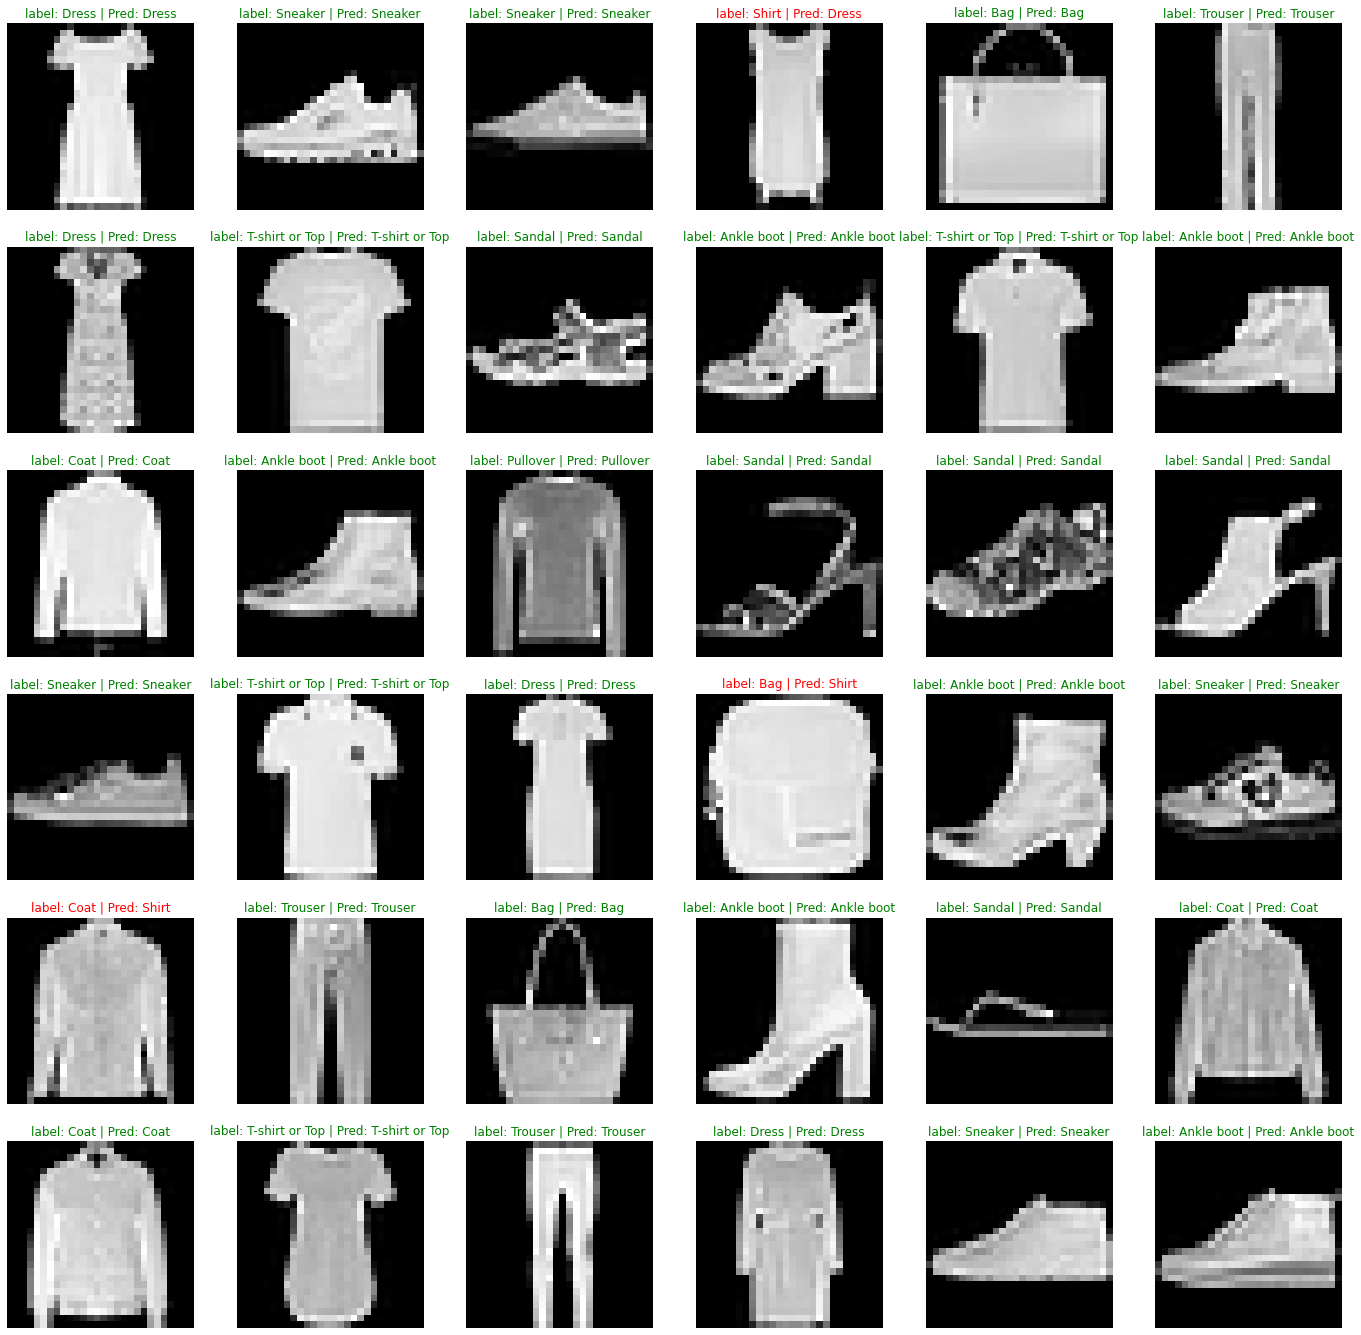

In [18]:
fig, axes = plt.subplots(6, 6, figsize = (24, 24))

for img, label, pred, ax in zip(feature, target, preds, axes.flatten()): #membubat datanya menjadi flat terlebih dahulu
    ax.imshow(img.view(28, 28).cpu(), cmap = 'gray') #mengatur jumlah image (28 x 28 sesuai di shapenya) dan warna
    font = {'color':'r'} if label != pred else {'color': 'g'} #mengatur kondisi warna jika true atau false
    label, pred = label2cat[label.item()], label2cat[pred.item()] #membuat hasil antara label (target) dan prediksinya (pred)
    ax.set_title(f'label: {label} | Pred: {pred}', fontdict = font); #memberi pernak-pernik judul dan labelnya
    ax.axis ('off');            